## How does the approximation of WH ~ X perform as we increase the rank k?

In [1]:
from ristretto import nmf
import numpy
import matplotlib.pyplot as plt
import pandas

def nmf_approximation_error(matrix, k, method = 'nmf_fhals'):
    if method == 'nmf_fhals':
        W,H = nmf.nmf_fhals(matrix, k)
        return numpy.linalg.norm(matrix - W.dot(H))
    elif method == 'rnmf_fhals':
        W,H = nmf.rnmf_fhals(matrix, k)
        return numpy.linalg.norm(matrix - W.dot(H))
    else:
        return None


nmf_error_tracker = {}
rnmf_error_tracker = {}
X = numpy.random.rand(1000,1000)
for k in range(200, 500, 50):
    nmf_error = []
    for trial in xrange(3):
        nmf_error.append(nmf_approximation_error(X, k, method = 'nmf_fhals'))
    nmf_error_tracker[k] = numpy.mean(nmf_error)

    rnmf_error = []
    for trial in xrange(3):
        rnmf_error.append(nmf_approximation_error(X, k, method = 'nmf_fhals'))
    rnmf_error_tracker[k] = numpy.mean(rnmf_error)

/Users/hyunjoonsong/Documents/MIT/MEng_Year/18.065/venv/lib/python2.7/site-packages/matplotlib/pyplot.py:3358: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


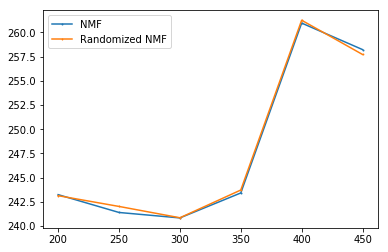

In [2]:
nmf_df = pandas.DataFrame([nmf_error_tracker.keys(), nmf_error_tracker.values()]).T.sort_values(0)
nmf_df.columns = ['x','y']
rnmf_df = pandas.DataFrame([rnmf_error_tracker.keys(), rnmf_error_tracker.values()]).T.sort_values(0)
rnmf_df.columns = ['x','y']
plt.plot('x', 'y', data = nmf_df, linestyle='-', marker='o', markersize = 1, label='NMF')
plt.plot('x', 'y', data = rnmf_df, linestyle='-', marker='d', markersize = 1, label='Randomized NMF')
plt.legend()
plt.show()
plt.close()

## NMF Code

In [1]:
import numpy
import nmf

X = numpy.random.rand(100,100)
X_sym = (X + X.T)/2

B,C = nmf.nmf_fhals(X_sym,100)
print (B == C.T).all()
print numpy.linalg.norm(B.dot(C) - X_sym)

False
4.7736319056352645


In [2]:
import time
start = time.time()
H = nmf.snmf_fhals(X_sym, 2)
print("Time elapsed: %f" % (time.time() - start))
print numpy.linalg.norm(H.dot(H.T) - X_sym)

Pushing Time Elapsed: 0.088173
Eval 1 Time Elapsed: 0.049641
Eval 2 Time Elapsed: 0.016487
Pushing Time Elapsed: 0.060408
Eval 1 Time Elapsed: 0.015697
Eval 2 Time Elapsed: 0.015818
Pushing Time Elapsed: 0.072752
Eval 1 Time Elapsed: 0.016380
Eval 2 Time Elapsed: 0.016427
Pushing Time Elapsed: 0.060997
Eval 1 Time Elapsed: 0.016006
Eval 2 Time Elapsed: 0.016335
Pushing Time Elapsed: 0.078025
Eval 1 Time Elapsed: 0.015218
Eval 2 Time Elapsed: 0.015475
Pushing Time Elapsed: 0.061643
Eval 1 Time Elapsed: 0.015687
Eval 2 Time Elapsed: 0.015839
Pushing Time Elapsed: 0.077110
Eval 1 Time Elapsed: 0.015785
Eval 2 Time Elapsed: 0.015473
Pushing Time Elapsed: 0.066011
Eval 1 Time Elapsed: 0.019152
Eval 2 Time Elapsed: 0.020488
Pushing Time Elapsed: 0.067627
Eval 1 Time Elapsed: 0.015736
Eval 2 Time Elapsed: 0.016608
Pushing Time Elapsed: 0.063564
Eval 1 Time Elapsed: 0.017226
Eval 2 Time Elapsed: 0.016622
Pushing Time Elapsed: 0.080304
Eval 1 Time Elapsed: 0.016890
Eval 2 Time Elapsed: 0.016930

Pushing Time Elapsed: 0.084704
Eval 1 Time Elapsed: 0.017270
Eval 2 Time Elapsed: 0.021079
Pushing Time Elapsed: 0.117370
Eval 1 Time Elapsed: 0.019366
Eval 2 Time Elapsed: 0.015472
Pushing Time Elapsed: 0.059699
Eval 1 Time Elapsed: 0.016975
Eval 2 Time Elapsed: 0.031220
Pushing Time Elapsed: 0.105839
Eval 1 Time Elapsed: 0.015262
Eval 2 Time Elapsed: 0.015208
Pushing Time Elapsed: 0.058723
Eval 1 Time Elapsed: 0.015388
Eval 2 Time Elapsed: 0.015485
Pushing Time Elapsed: 0.072777
Eval 1 Time Elapsed: 0.023535
Eval 2 Time Elapsed: 0.015170
Pushing Time Elapsed: 0.058354
Eval 1 Time Elapsed: 0.018249
Eval 2 Time Elapsed: 0.015306
Pushing Time Elapsed: 0.069463
Eval 1 Time Elapsed: 0.015577
Eval 2 Time Elapsed: 0.015303
Pushing Time Elapsed: 0.057377
Eval 1 Time Elapsed: 0.016268
Eval 2 Time Elapsed: 0.015205
Pushing Time Elapsed: 0.073270
Eval 1 Time Elapsed: 0.015219
Eval 2 Time Elapsed: 0.015855
Pushing Time Elapsed: 0.132183
Eval 1 Time Elapsed: 0.036962
Eval 2 Time Elapsed: 0.032027

Pushing Time Elapsed: 0.059597
Eval 1 Time Elapsed: 0.014840
Eval 2 Time Elapsed: 0.014844
Pushing Time Elapsed: 0.057428
Eval 1 Time Elapsed: 0.015220
Eval 2 Time Elapsed: 0.015011
Pushing Time Elapsed: 0.066376
Eval 1 Time Elapsed: 0.016580
Eval 2 Time Elapsed: 0.016475
Pushing Time Elapsed: 0.063015
Eval 1 Time Elapsed: 0.020354
Eval 2 Time Elapsed: 0.016269
Pushing Time Elapsed: 0.058529
Eval 1 Time Elapsed: 0.015203
Eval 2 Time Elapsed: 0.015050
Time elapsed: 32.118074
19.912875214658204


In [5]:
from oct2py import octave
octave.addpath("/Users/hyunjoonsong/Documents/MIT/MEng_Year/18.065/symnmf")
octave.push('X_sym', X_sym)
start = time.time()
H = octave.eval('symnmf_anls(X_sym, 2)', verbose=False)
print("Time elapsed: %f" % (time.time() - start))
print numpy.linalg.norm(H.dot(H.T) - X_sym)

Time elapsed: 0.111830
19.96280428293382


In [3]:
from sklearn.decomposition import NMF

model = NMF(n_components=100, init='random', random_state=0)
W = model.fit_transform(X_sym)
H = model.components_

In [4]:
numpy.linalg.norm(W.dot(H) - X)

20.684412339240485

In [23]:
import numpy
genomes = numpy.load('CEU_YRI_ASW_34866.npy').astype(numpy.float64)

In [24]:
W, H = nmf.nmf_fhals(genomes.T,2)
W_norm = W/W.sum(axis = 1)[:, numpy.newaxis]

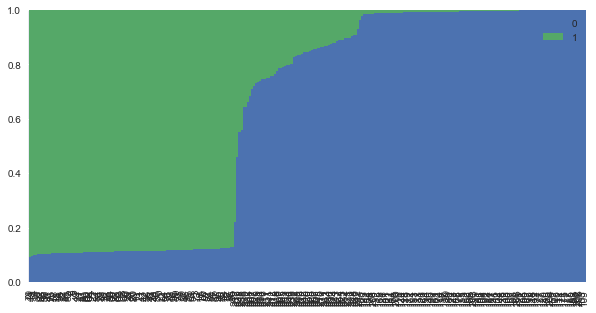

In [36]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
pandas.DataFrame(W_norm).sort_values(0).plot(kind='bar', stacked=True, linewidth = 0, figsize = (10,5), width=1.0)
plt.ylim(0,1)
plt.show()
plt.close()

In [28]:
rW, rH = nmf.rnmf_fhals(genomes.T,2)
rW_norm = rW/rW.sum(axis = 1)[:, numpy.newaxis]

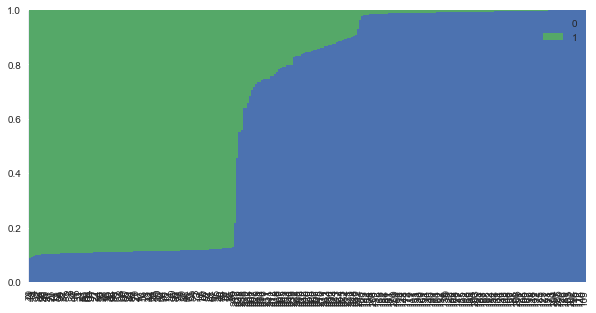

In [35]:
sns.set()
pandas.DataFrame(rW_norm).sort_values(0).plot(kind='bar', stacked=True, linewidth = 0, figsize = (10,5), width=1.0)
plt.ylim(0,1)
plt.show()
plt.close()

In [30]:
from scipy import stats
import scipy


In [31]:
corr = numpy.zeros((len(genomes.T),len(genomes.T)))
for i in xrange(len(genomes.T)):
    for j in xrange(len(genomes.T)):
        corr[i,j] = stats.pearsonr(genomes.T[i],genomes.T[j])[0]

In [49]:
H_orig, H_t = nmf.snmf_fhals(corr,2)
#H_orig = octave.symnmf_newton(corr, 2)

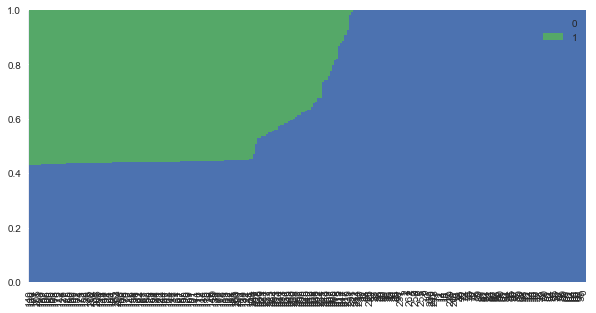

In [50]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
pandas.DataFrame(H_orig/H_orig.sum(axis = 1)[:, numpy.newaxis]).sort_values(0).plot(kind='bar', stacked=True, linewidth = 0, figsize = (10,5), width=1.0)
plt.ylim(0,1)
plt.show()
plt.close()

In [26]:
numpy.linalg.norm(H_orig.dot(H_t) - corr)

85.323361393065056

In [25]:
H_orig.dot(H_t)

array([[ 0.00162681,  0.00164476,  0.00161666, ...,  0.00269667,
         0.00273059,  0.00269094],
       [ 0.00164476,  0.0016629 ,  0.00163449, ...,  0.00272641,
         0.00276071,  0.00272062],
       [ 0.00161666,  0.00163449,  0.00160656, ...,  0.00267983,
         0.00271354,  0.00267414],
       ..., 
       [ 0.00269667,  0.00272641,  0.00267983, ...,  0.00475767,
         0.004782  ,  0.00478877],
       [ 0.00273059,  0.00276071,  0.00271354, ...,  0.004782  ,
         0.00481057,  0.00480848],
       [ 0.00269094,  0.00272062,  0.00267414, ...,  0.00478877,
         0.00480848,  0.00482563]])